# Fuzzy rules
The goal of this notebook is to provide one implementation of fuzzy rule allowing you to explore the process of creation of rules in a fuzzy inference system

In [19]:
import numpy as np
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib inline

The implementation of the linguistic variable is not written here. Instead it is loaded from a python file.

In [2]:
import linguistic_variable as lv

The constructor of the provided implementation of the fuzzy rule receives 4 arguments:
- operation: a string containing the type of fuzzy operation to compute the activation of the antecedent. Possible values are:
    - AND_min: minimum
    - AND_prod: product
    - AND_bounprod: bounded product
    - OR_max: maximum
    - OR_probsum: probabilistic sum
    - OR_boundsum: bounded sum
- antecedent: a list of tuples (linguistic_variable, linguistic_value) with the antetecedent of the rule to be created. Linguistic variables are of type LinguisticVariable (in file linguistic_variable.py), linguistic values are specified by name witha string
- consequent: a tuple (linguistic_variable, linguistic_value) with the consequent of the rule to be created. Linguistic variables are of type LinguisticVariable (in file linguistic_variable.py), linguistic values are specified by name witha string
- implication: the implication operation to be used. Possible values are:
    - MIN: minimum
    - PROD: product

In [138]:
class FuzzyRule:
    """
    This class implements a fuzzy rule.
    A single type of operation per rule is allowed. Yo can choose between:
    AND - minimum
    AND - product
    AND - bounded product
    OR  - maximum
    OR  - probabilistic sum
    OR  - bounded sum
    """
    
    __fuzzy_operations_names = {'AND_min':'AND', 'AND_prod':'AND', 'AND_boundprod':'AND', 'OR_max':'OR', 'OR_probsum':'OR', 'OR_boundsum':'OR'}
    __fuzzy_operations = {'AND_min': np.min,
                          'AND_prod': np.prod,
                          'AND_boundprod': lambda x: np.max([0, np.sum(x) - 1]),
                          'OR_max': np.max,
                          'OR_probsum': lambda x: np.sum(x) - np.prod(x),
                          'OR_boundsum': lambda x: np.min([1, np.sum(x)])}
    __fuzzy_implication = {'MIN': np.minimum,
                           'PROD': np.prod}
    
    def __init__(self, operation, antecedent, consequent, implication):
        """
        Three parameters are needed:
        operation: the fuzzy operation to perform
        antecedent: a list of tuples [(linguistic_variable, linguistic_value),...] defining the input fuzzy condition
        consequent: a tuple (linguistic_variable, linguistic_value) defining the output fuzzy assignement
        """
        assert operation in self.__fuzzy_operations.keys()
        assert implication in self.__fuzzy_implication.keys()
        self.operation = operation
        self.antecedent = antecedent
        self.consequent = consequent
        self.implication = implication
        self.antecedent_activation = 0.0
        self.consequent_activation = np.zeros(len(consequent[0].input_values))
    
    def __str__(self):
        to_return = 'Fuzzy rule:\n\tIF '
        for i, pair in enumerate(self.antecedent):
            to_return += pair[0].name + ' IS ' + pair[1]
            if i < (len(self.antecedent) - 1):
                to_return += ' ' + self.__fuzzy_operations_names[self.operation] + ' '
        to_return += '\n\tTHEN ' + self.consequent[0].name + ' is ' +  self.consequent[1]
        to_return += '\n\tAntecedent activation: ' + str(self.antecedent_activation)
        return to_return
    
    def compute_antecedent_activation(self, input_values):
        """
        This function computes the activation of the antecedent of the rule.
        The first step is the fuzzification of the input values. Then, the activation
        is computed by applying the fuzzy operation to the values of the  membership functions.
        """
        temp = []
        for pair in self.antecedent:
            val = input_values.get(pair[0].name)
            if val:
                membership_values = pair[0].fuzzify(val)
                temp.append(membership_values[pair[1]])
        self.antecedent_activation = self.__fuzzy_operations[self.operation](temp)
        return self.antecedent_activation
    
    def compute_consequent_activation(self):
        """
        This function applies the causal implication operator in order to compute
        the activation of the rule's consequent.
        """
        self.consequent_activation = self.consequent[0].get_linguistic_value(self.consequent[1])
        self.consequent_activation = self.__fuzzy_implication[self.implication](self.antecedent_activation, self.consequent_activation)
        return self.consequent_activation
    
    def plot(self):
        pl.plot(self.consequent[0].input_values, self.consequent_activation, label=self.consequent[1])
        pl.ylim(0, 1.05)
        pl.legend()
        pl.title(self.consequent[0].name)
        pl.grid()

    def plot2D(self, ax=None):
        """
        Only works if the rule has two input variables!
        """
        assert len(self.antecedent) == 2
        
        var1 = self.antecedent[0][0]
        var2 = self.antecedent[1][0]
        n_var1 = len(var1.input_values)
        n_var2 = len(var2.input_values)
        val1 = self.antecedent[0][1]
        val2 = self.antecedent[1][1]
        
        membership_var1 = var1.get_linguistic_value(val1)
        membership_var2 = var2.get_linguistic_value(val2)
        membership_var1_2D = np.tile(membership_var1, n_var2).reshape(n_var2, n_var1)
        membership_var2_2D = np.tile(membership_var2, n_var1).reshape(n_var1, n_var2).T
        
        X, Y = np.meshgrid(var1.input_values, var2.input_values)
        Z = np.reshape(map(self.__fuzzy_operations[self.operation], zip(membership_var1_2D.flatten(), membership_var2_2D.flatten())), membership_var1_2D.shape)

        if ax is None:
            ax = pl.gca(projection='3d')
        ax.plot(var1.input_values, np.zeros(n_var1), membership_var1, 'r--')
        ax.plot(var1.input_values, max(var2.input_values)*np.ones(n_var1), membership_var1, 'r--')
        ax.plot(np.zeros(n_var2), var2.input_values, membership_var2, 'b--')
        ax.plot(max(var1.input_values)*np.ones(n_var2), var2.input_values, membership_var2, 'b--')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        ax.set_xlabel(var1.name)
        ax.set_ylabel(var2.name)
        ax.set_zlabel(self.operation)

## An example: "The tourists prediction problem"
Let's first create the three linguistic variables involved in the problem:
- temperature
- sunshine
- tourists

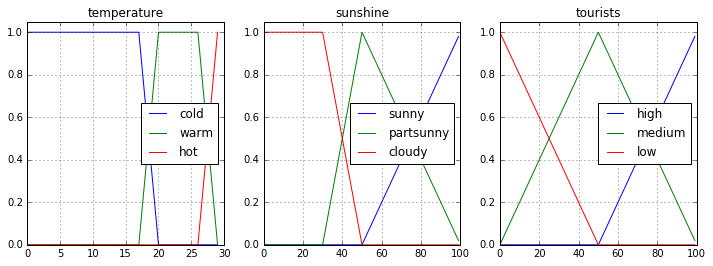

In [144]:
temperature = lv.LinguisticVariable('temperature', 0, 30, [17, 20, 26, 29], ['cold', 'warm', 'hot'], res=1)
sunshine = lv.LinguisticVariable('sunshine', 0, 100, [30, 50, 50, 100], ['cloudy', 'partsunny', 'sunny'], res=1)
tourists = lv.LinguisticVariable('tourists', 0, 100, [0, 50, 50, 100], ['low', 'medium', 'high'], res=1)

pl.figure(figsize=(12,4))
pl.subplot(1,3,1)
temperature.plot()
pl.subplot(1,3,2)
sunshine.plot()
pl.subplot(1,3,3)
tourists.plot()

Now we can define some inputs to the rule, in order to test how it works

In [86]:
input_values = {'temperature': 19, 'sunshine': 60}

The first rule in the tourists prediction problem:

In [139]:
fr_1 = FuzzyRule('OR_max', [(temperature,'hot'), (sunshine, 'sunny')], (tourists, 'high'), 'MIN')

In [145]:
print fr_1

Fuzzy rule:
	IF temperature IS hot OR sunshine IS sunny
	THEN tourists is high
	Antecedent activation: 0.0


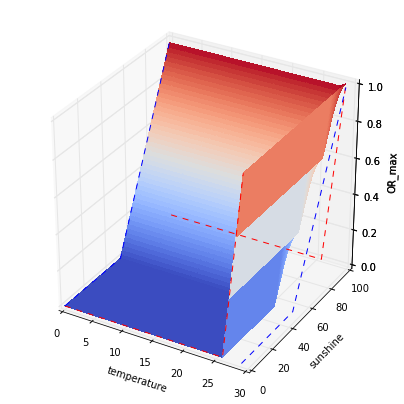

In [148]:
pl.figure(figsize=(7,7))
fr_1.plot2D()

### Antecedent activation

In [8]:
print 'Rule 1, antecedent activation: ', fr_1.compute_antecedent_activation(input_values)
print 'Rule 2, antecedent activation: ', fr_2.compute_antecedent_activation(input_values)
print 'Rule 3, antecedent activation: ', fr_3.compute_antecedent_activation(input_values)

Rule 1, antecedent activation:  0.2
Rule 2, antecedent activation:  0.666666666667
Rule 3, antecedent activation:  0.333333333333


### Implication

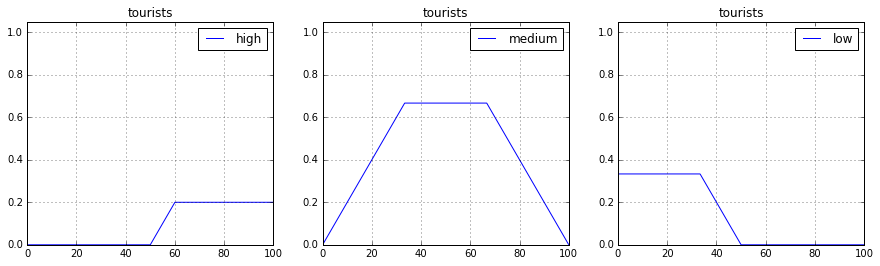

In [9]:
pl.figure(figsize=(15,4))
pl.subplot(1,3,1)
fr_1.compute_consequent_activation()
fr_1.plot()
pl.subplot(1,3,2)
fr_2.compute_consequent_activation()
fr_2.plot()
pl.subplot(1,3,3)
fr_3.compute_consequent_activation()
fr_3.plot()

## Exercise
Create the complete set of rules of the tourists prediction problem, and compute the consequent activation for several input values

In [ ]:
fr_1 = FuzzyRule('OR_max', [(temperature,'hot'), (sunshine, 'sunny')], (tourists, 'high'), 'MIN')
fr_2 = FuzzyRule('AND_min', [(temperature,'warm'), (sunshine, 'partsunny')], (tourists, 'medium'), 'MIN')
fr_3 = FuzzyRule('OR_max', [(temperature,'cold'), (sunshine, 'cloudy')], (tourists, 'low'), 'MIN')